<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/ROAA_DSAI305_Project_MODEL_TABNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on the paper https://www.politesi.polimi.it/retrieve/275d883a-78a3-4206-a3a4-ae0a93d9a41a/Master_Thesis_Arnaldo_Mollo.pdf  

I'll implement the TabNet model (which showed the best balance between performance and interpretability) and demonstrate four different explainability techniques.

`final_loan_data_leakproof.csv` - The main dataset with selected features from the EDA noteboook

`engineered_loan_data_leakproof.pkl `- Engineered features (if needed)

`processed_loan_data.pkl` - Fully processed data (if needed)

# IMPORTS

In [ ]:
!pip install pytorch_tabnet
!pip install lime
!pip install pdpbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
import shap
import lime
import lime.lime_tabular
from pdpbox import pdp, info_plots
import torch
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
final_df = pd.read_csv('final_loan_data_leakproof.csv')

In [ ]:
print("Shape:", final_df.shape)
print("Columns:", final_df.columns.tolist())

Shape: (50000, 17)
Columns: ['addr_state_MI', 'verification_status_Verified', 'home_ownership_RENT', 'loan_status_Fully Paid', 'sub_grade', 'dti_ratio', 'issue_d_year', 'dti', 'int_rate', 'grade', 'term_ 60 months', 'loan_to_income', 'home_ownership_MORTGAGE', 'debt_settlement_flag_Y', 'issue_d_month', 'credit_history_years', 'target']


In [ ]:
X = final_df.drop(columns=['target', 'loan_status_Fully Paid', 'debt_settlement_flag_Y'])
y = final_df['target']

In [ ]:
# convert boolean columns to int
bool_columns = X.select_dtypes(include=['bool']).columns
for col in bool_columns:
    X[col] = X[col].astype(int)

In [ ]:
# y is integer (binary: 0 or 1)
if not np.issubdtype(y.dtype, np.integer):
    y = y.astype(np.int64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Convert to numpy arrays
X_train = X_train.values.astype(np.float32)  #  float for features
X_test = X_test.values.astype(np.float32)

y_train = y_train.values.astype(np.int64)     # int for labels
y_test = y_test.values.astype(np.int64)

# MODEL TABNET

In [ ]:
# tabnet model with hyperparameters as in the research paper using pytorch

tabnet_params = {
    "n_d": 64,
    "n_a": 64,
    "n_steps": 5,
    "gamma": 1.6,
    "n_independent": 2,
    "n_shared": 2,
    "mask_type": "entmax",
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2, weight_decay=1e-5),
    "scheduler_fn": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    "scheduler_params": dict(T_0=10, T_mult=2, eta_min=1e-4),
    "seed": 42,
    "verbose": 1,
}

**hyperparameters mentioned in the paper include:**

* n_d (decision prediction layer dimension): Controls the size of the decision output. the paper Suggests n_d can range from 8 to 64, with larger values for larger datasets, here we implemented dimension of 64 .

* n_a (attention embedding dimension): Size of the attention embedding, stated in paper to be equal to n_d for consistency, as attention embeddings should match decision output size.

* n_steps (number of decision steps): Number of sequential attention steps, paper states that it is recommended 3 to 10 steps, with 5 being a common default for balancing performance and interpretability.

* gamma (relaxation parameter): Controls the sparsity of feature selection, paper suggests gamma between 1.0 and 2.0, and 1.6 being common for sparsity control.

* n_independent (number of independent Gated Linear Units in the feature transformer): paper Recommends 1 to 5 independent GLUs, with 2 being a reasonable default for moderate complexity.

* n_shared (number of shared GLUs across steps): paper Recommends 1 to 5 independent GLUs, with 2 being a reasonable default for moderate complexity.

* mask_type: Type of masking function, either "sparsemax" or "entmax", paper suggests "entmax" emphasis on sparse attention.

* optimizer_fn: adam optimizer.

* optimizer_params: paper recommends a learning rate of 0.02 (2e-2) and small weight decay (e.g., 1e-5) for regularization.

* scheduler_fn: Learning rate scheduler, we used CosineAnnealingWarmRestarts, with parameters T_0 (initial period), T_mult (multiplier for period), and eta_min (minimum learning rate) with values (T_0=10, T_mult=2, eta_min=1e-4) are standard for CosineAnnealingWarmRestarts in pytorch.


In [ ]:
#initialize
TabNetClassifier = TabNetClassifier(**tabnet_params)

In [ ]:
#train
TabNetClassifier.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['test'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.63803 | test_auc: 0.63556 | test_accuracy: 0.4361  |  0:00:19s
epoch 1  | loss: 0.48052 | test_auc: 0.52825 | test_accuracy: 0.6899  |  0:00:28s
epoch 2  | loss: 0.47081 | test_auc: 0.59846 | test_accuracy: 0.7926  |  0:00:38s
epoch 3  | loss: 0.4721  | test_auc: 0.61038 | test_accuracy: 0.7672  |  0:00:49s
epoch 4  | loss: 0.46817 | test_auc: 0.67845 | test_accuracy: 0.7687  |  0:00:59s
epoch 5  | loss: 0.46543 | test_auc: 0.67471 | test_accuracy: 0.7846  |  0:01:10s
epoch 6  | loss: 0.4644  | test_auc: 0.68044 | test_accuracy: 0.7729  |  0:01:19s
epoch 7  | loss: 0.4641  | test_auc: 0.67014 | test_accuracy: 0.7977  |  0:01:33s
epoch 8  | loss: 0.463   | test_auc: 0.67941 | test_accuracy: 0.7835  |  0:01:43s
epoch 9  | loss: 0.46229 | test_auc: 0.68375 | test_accuracy: 0.7947  |  0:01:54s
epoch 10 | loss: 0.46863 | test_auc: 0.68498 | test_accuracy: 0.797   |  0:02:04s
epoch 11 | loss: 0.46733 | test_auc: 0.64268 | test_accuracy: 0.7975  |  0:02:16s
epoch 12 | loss:

In [ ]:
# Evaluate model
y_pred = TabNetClassifier.predict(X_test)                      #array with predicted class labels (binary)
y_proba = TabNetClassifier.predict_proba(X_test)[:, 1]         #array with predicted probabilities for the default class

In [ ]:
print("\nModel Evaluation:")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba)}")


Model Evaluation:
Accuracy: 0.8008
Precision: 0.5682819383259912
Recall: 0.06376668314384577
F1 Score: 0.11466666666666667
AUC-ROC: 0.7073615810060945


# Explainability Technique 1: feature  importance

In [ ]:
feature_names = final_df.drop(columns=['target', 'loan_status_Fully Paid' , 'debt_settlement_flag_Y']).columns.tolist()

In [ ]:
feature_importances = TabNetClassifier.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]                     # from most to least important,

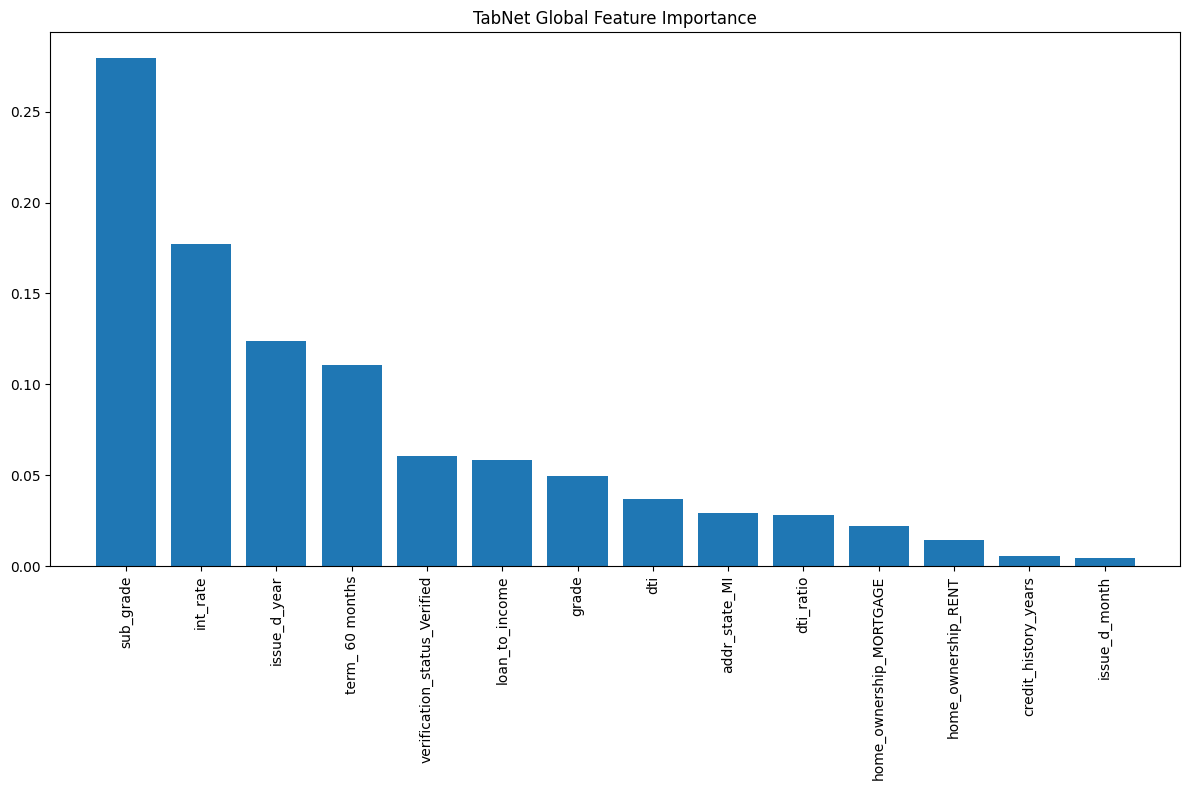

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("TabNet Global Feature Importance")

plt.bar(range(X.shape[1]), feature_importances[sorted_idx], align='center')
plt.xticks(range(X.shape[1]), np.array(X.columns)[sorted_idx], rotation=90)
plt.xlim([-1, X.shape[1]])

plt.tight_layout()
plt.show()

# Explainability Technique 2: SHAP Values

In [ ]:
# wrapper function that predict probabilities for the default class

def predict_proba_wrapper(X):
    probs = TabNetClassifier.predict_proba(X.astype(np.float32))[:, 1]
    return np.clip(probs, 0, 1)

In [ ]:
# Use a subset of training data as background

background = X_train[:100].copy()

In [ ]:
shap_explainer = shap.KernelExplainer(predict_proba_wrapper, background)

In [ ]:
# Calculate shap values for a subset of test data

test_samples = X_test[:100]
shap_values = shap_explainer.shap_values(test_samples, nsamples=200)

  0%|          | 0/100 [00:00<?, ?it/s]

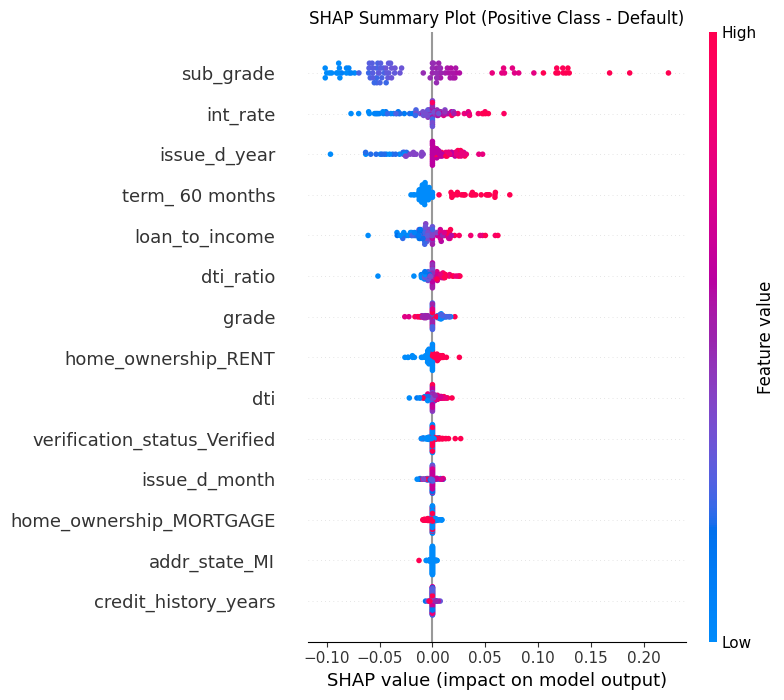

In [ ]:
# summary plot


plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    test_samples,
    feature_names=X.columns.tolist(),
    max_display=20,
    plot_type="dot",
    show=False
)
plt.title("SHAP Summary Plot (Positive Class - Default)")
plt.tight_layout()
plt.show()

Top Risk Factors (Increase Default Chance):

* Right-side values (red) = higher risk
  - grade
  - sub_grade
  - int_rate
  - debt_settelement
  - loan_to_income
  - dti


# Explainability Technique 3: LIME

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['Non-Default', 'Default'],
    mode='classification',
    discretize_continuous=True
)

In [ ]:
sample_idx = 0

exp = lime_explainer.explain_instance(
    X_test[sample_idx],
    TabNetClassifier.predict_proba,
    num_features=20,
    top_labels=1
)

exp.show_in_notebook(show_table=True, show_all=False)

The model predicts a 76% probability that this loan will not default (Non-Default) and a 24% probability that it will default. Since 0.76 > 0.24, the model’s final prediction is Non-Default.

Key factors for this prediction:

Loan term (36 months vs 60)

High loan-to-income ratio (0.41)

Sub-grade category (2.40)

High DTI (45.70)

# Explainability Technique 4: Partial Dependence Plots

In [ ]:
N = 10  # top N features based on mean absolute shap values above

feature_importance = np.abs(shap_values).mean(0)
top_feature_indices = feature_importance.argsort()[-N:][::-1]
top_features = [feature_names[idx] for idx in top_feature_indices]

print(f"top {N} features: {top_features}")

Top 10 features: ['sub_grade', 'int_rate', 'issue_d_year', 'term_ 60 months', 'loan_to_income', 'dti_ratio', 'grade', 'home_ownership_RENT', 'dti', 'verification_status_Verified']


In [ ]:
# binary and non-binary features

binary_features = ['term_ 60 months', 'home_ownership_RENT', 'verification_status_Verified']
non_binary_features = ['sub_grade', 'int_rate', 'issue_d_year', 'loan_to_income', 'dti_ratio', 'grade', 'dti']


Binary features: ['term_ 60 months', 'home_ownership_RENT', 'verification_status_Verified']
Non-binary features: ['sub_grade', 'int_rate', 'issue_d_year', 'loan_to_income', 'dti_ratio', 'grade', 'dti']


In [ ]:
# Custom PDP function for non-binary features

def compute_pdp(model, X, feature_idx, feature_name, grid_resolution=50):
    X_copy = X.copy()
    unique_values = np.unique(X[:, feature_idx])

    if len(unique_values) < grid_resolution: #categorical or ordinal features
        grid = unique_values
    else:                                    #continous features
        grid = np.linspace(min(unique_values), max(unique_values), grid_resolution)

    pdp_values = []
    for val in grid:
        X_copy[:, feature_idx] = val
        probs = model.predict_proba(X_copy.astype(np.float32))[:, 1]
        pdp_values.append(np.mean(probs))

    return grid, pdp_values

because standard pdp libraries assume scikit-learn-compatible models, and tabnet implemented with pytorch (as noted in the paper), outputs probabilities via predict_proba, which returns a numpy array of shape (n_samples, n_classes).

in order to handle both continuous and discrete features:
* (categorical or ordinal features like sub_grade) --> use the actual values (grid = unique_values).

* (continuous features like dti, loan_amnt) --> creates a grid_resolution evenly spaced points

Generating Partial Dependence Plots for non-binary features...


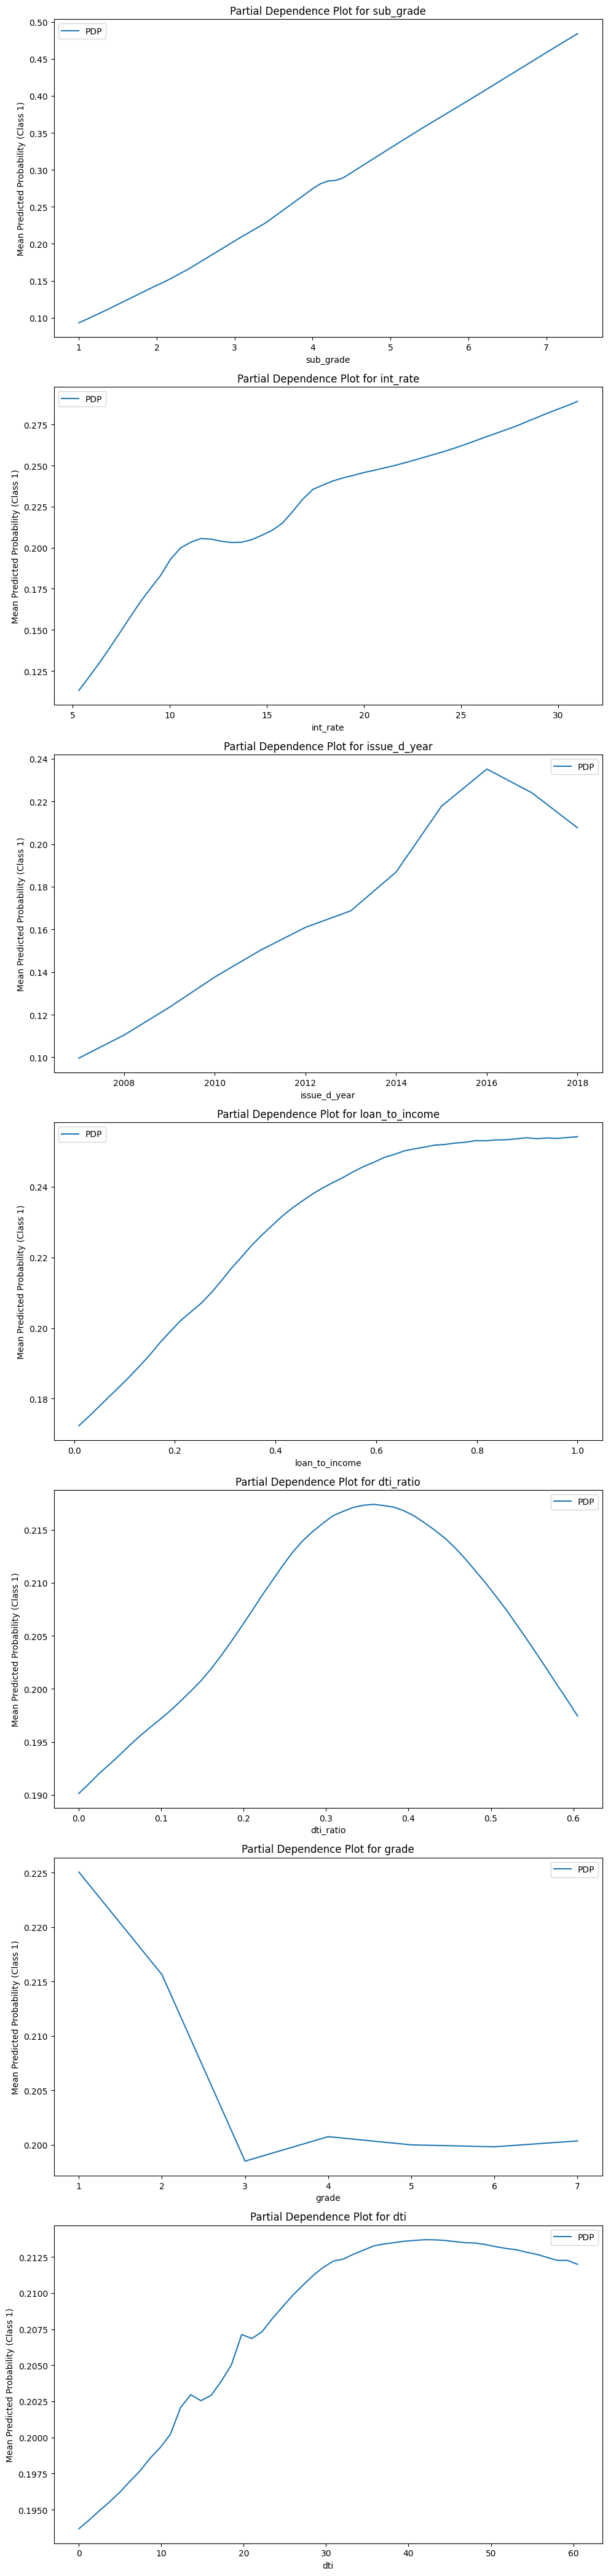

In [ ]:
# Generate PDPs for non-binary features

n_non_binary = len(non_binary_features)

fig, axes = plt.subplots(n_non_binary, 1, figsize=(10, 6 * n_non_binary), sharex=False)

if n_non_binary == 1:
    axes = [axes]

for idx, (feature_idx, feature_name) in enumerate(non_binary_features):
      grid, pdp_values = compute_pdp(TabNetClassifier, X_test, feature_idx, feature_name)

      axes[idx].plot(grid, pdp_values, label='PDP')
      axes[idx].set_xlabel(feature_name)

      axes[idx].set_ylabel('mean predicted probability (class 1)')
      axes[idx].set_title(f"partial dependence plot for {feature_name}")

      axes[idx].legend()

plt.tight_layout()
plt.savefig('pdp_plots_non_binary_features.png')
plt.show()
plt.close()


* Directly proprotional features the higher the value the higher the risk of deafault : Higher `sub_grade` , `dti` , `loan_to_income`, `int_rate` values increase the predicted probability of default, reflecting increased risk.

* The `issue_d_year` peaks around 2014–2015, indicating higher risk during that years